# Hydrogeodesy: Monitoring surface waters from space
### Exercise 2: Comparison of different inland altimetry products

Daniel Scherer, DGFI-TUM  
Wintersemester 2022/23

**Contents**
1. Reading NetCDF formatted data
2. Data processing
3. Quality assessment

**Study Area: Lake Erie (USA)**  
![AOI](aoi.Png)  
*Figure 1: Lake Erie with intersecting satellite altimetry passes. Red: Topex/Poseidon and Jason-1/-2 missions. Blue: ERS-2 and Envisat missions*  

Water Level Variation: 173 – 176 m

Following data is used in this exercise:  

| Dataset | Institution | Epoche | Samples | Filename |
| --- | --- | --- | --- | --- |
| [In-Situ](https://tidesandcurrents.noaa.gov/waterlevels.html?id=9063053) | NOAA | 1992-2015 | 8489 (daily) | gauge_33.nc |
| [DAHITI](https://dahiti.dgfi.tum.de/en/6/water-level-altimetry/) | DGFI-TUM | 1992-2017 | 2289 | dahiti_6.nc |
| [Hydroweb](https://hydroweb.theia-land.fr/hydroweb/view/L_erie?lang=en) | LEGOS | 1992-2011 | 222 | hydroweb_1560.nc |
| [River&Lake](http://altimetry.esa.int/riverlake/shared/main.html) | ESA | 2002-2010 | 81 | Esa_778.nc |
| [GRLM](https://ipad.fas.usda.gov/cropexplorer/global_reservoir/gr_regional_chart.aspx?regionid=us&reservoir_name=Erie) | USDA | 1992-2014 | 752 | grlm_75.nc |


#### 1. Reading NetCDF formatted data
Use the netcdf4 package to read NetCDF data in python.  
e.g. the DAHITI data:

In [1]:
import netCDF4 as nc
dset = nc.Dataset('data/dahiti_6.nc')

You can get information about the data set by just printing it:

In [2]:
print(dset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    institution: DGFI-TUM
    target: Erie, Lake
    source: DAHITI
    creation_date: 2017-11-27 07:26:33
    dimensions(sizes): time(2289)
    variables(dimensions): float64 jday(time), float64 height(time)
    groups: 


And inspect the variables and dimensions by:

In [3]:
print(dset.variables)

{'jday': <class 'netCDF4._netCDF4.Variable'>
float64 jday(time)
    standard_name: Julian day epoch 2000.0 (2000-01-01 12:00:00 UTC)
unlimited dimensions: 
current shape = (2289,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'height': <class 'netCDF4._netCDF4.Variable'>
float64 height(time)
    standard_name: Height
unlimited dimensions: 
current shape = (2289,)
filling on, default _FillValue of 9.969209968386869e+36 used}


You can access a variable as shown, it will return a numpy array:

In [4]:
heights_dahiti = dset['height'][:]
print(type(heights_dahiti))
print(heights_dahiti)

<class 'numpy.ma.core.MaskedArray'>
[174.3016616  174.16311682 174.24580321 ... 173.80308004 173.81608698
 173.82747247]


It is good practice to eventually close the dataset to prevent memory leaks and permission issues:

In [5]:
dset.close()

Extract the water level data from the files in the *data* folder.  
To make the following steps easier, we create a ***[Pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html)*** object for each source.  
The data of the series should be the water level and the index should be the respective julian days.

In [6]:
import pandas as pd

dset = nc.Dataset('data/dahiti_6.nc')
dahiti = pd.Series(data = dset['height'][:], index = dset['jday'][:])
dset.close()

dset = nc.Dataset('data/esa_778.nc')
esa = pd.Series(data = dset['height'][:], index = dset['jday'][:])
dset.close()

dset = nc.Dataset('data/gauge_33.nc')
gauge = pd.Series(data = dset['height'][:], index = dset['jday'][:])
dset.close()

dset = nc.Dataset('data/grlm_75.nc')
grlm = pd.Series(data = dset['height'][:], index = dset['jday'][:])
# Somehow the GRLM data contains duplicated entries but we keep only the first:
grlm = grlm[~grlm.index.duplicated(keep='first')]
dset.close()

dset = nc.Dataset('data/hydroweb_1560.nc')
hw = pd.Series(data = dset['height'][:], index = dset['jday'][:])
dset.close()

Plot the Data:

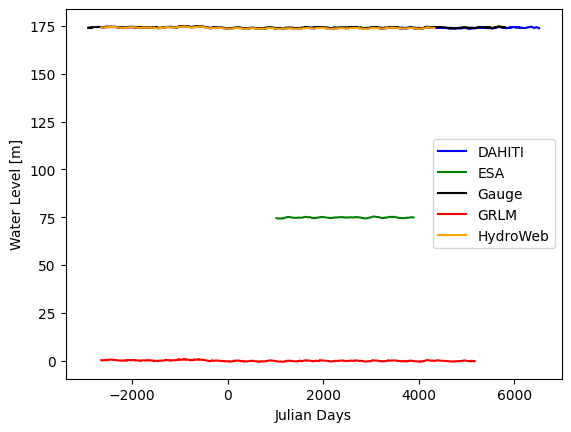

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
dahiti.plot(ax=ax,color="blue",legend=True,label='DAHITI')
esa.plot(ax=ax,color="green",legend=True,label='ESA')
gauge.plot(ax=ax,color="black",legend=True,label='Gauge')
grlm.plot(ax=ax,color="red",legend=True,label='GRLM')
hw.plot(ax=ax,color="orange",legend=True,label='HydroWeb')
plt.ylabel("Water Level [m]")
plt.xlabel("Julian Days")
plt.show()

As you can see, there are significant offsets between the time series, as they relate to different references.  
We will fix this in the next steps.

#### 2. Data Processing

Prepare the data to compare each altimetry dataset (dahiti, hydroweb, esa, grlm) with the in-situ gauge data.

There may be an offset between both datasets, e.g. because of different vertical datums, which should be removed.

We do ot need to find intersecting days of observations in advance, because we use the pandas series objects.  
The index (julian days) is automatically compared during the operations:

In [8]:
offset_dahiti = (gauge - dahiti).median()
dahiti += offset_dahiti

Compute and apply the offset for each dataset and plot the data as above:

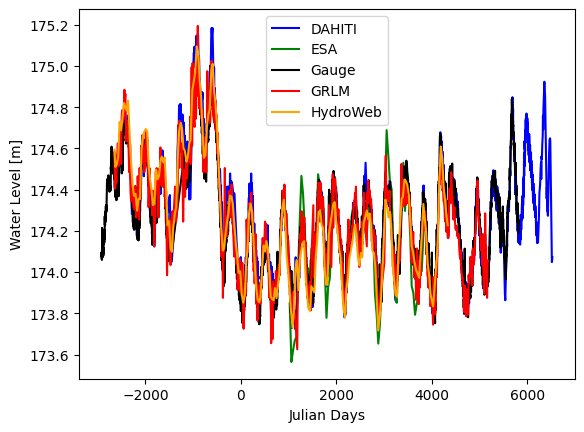

In [9]:
offset_hw = (gauge - hw).median()
hw += offset_hw
offset_esa = (gauge - esa).median()
esa += offset_esa
offset_grlm = (gauge - grlm).median()
grlm += offset_grlm

fig, ax = plt.subplots()
dahiti.plot(ax=ax,color="blue",legend=True,label='DAHITI')
esa.plot(ax=ax,color="green",legend=True,label='ESA')
gauge.plot(ax=ax,color="black",legend=True,label='Gauge')
grlm.plot(ax=ax,color="red",legend=True,label='GRLM')
hw.plot(ax=ax,color="orange",legend=True,label='HydroWeb')
plt.ylabel("Water Level [m]")
plt.xlabel("Julian Days")
plt.show()

#### Quality Assessment

Build functions to calculate the **Root Mean Square Error (RMSE), Nash-Sutcliff Efficiency (NSE), and squared Pearson's correlation coefficient (R²)** between both datasets.

The formulas are given in the lecture slides "Satellite Altimetry (Part 2)" pp. 47ff.

You can either use pandas buildin functions (*i.e. (series_a - series_b).mean()*) or numpy on the intersection of both series:

    idx = series_a.index.intersection(series_b.index)
    array_a, array_b = series_a[idx].to_numpy(), series_b[idx].to_numpy()
    
Useful numpy functions are:
- np.power(*base, exponent*)
- np.sum(*values*)
- np.cov(*values_a, values_b*)
- np.std(*values*)
- np.mean(*values*)

In [10]:
import numpy as np
def rmse(a, b):
    return np.sqrt(((a - b).pow(2)).mean())

def corr(a, b):
    idx = a.index.intersection(b.index)
    a, b = a.loc[idx].to_numpy(), b.loc[idx].to_numpy()
    val = np.cov(a, b)[0,1] / (np.std(a) * np.std(b))
    return val*val

def nse(a,b):
    """
    a : altimetry heights
    b : insitu_heights
    """
    idx = a.index.intersection(b.index)
    a, b = a.loc[idx], b.loc[idx]
    upper = ((b-a).pow(2)).sum()
    lower = ((b-b.mean()).pow(2)).sum()
    return 1 - (upper/lower)


Apply the functions to compare each dataset with insitu.  
Don't forget to calculate and apply the offset for each dataset.  

In [11]:
rmse_dahiti = rmse(dahiti,gauge)
corr_dahiti = corr(dahiti,gauge)
nse_dahiti = nse(dahiti,gauge)

rmse_hw = rmse(hw,gauge)
corr_hw = corr(hw,gauge)
nse_hw = nse(hw,gauge)

rmse_esa = rmse(esa,gauge)
corr_esa = corr(esa,gauge)
nse_esa = nse(esa,gauge)

rmse_grlm = rmse(grlm,gauge)
corr_grlm = corr(grlm,gauge)
nse_grlm = nse(grlm,gauge)

#### 3. Quality Assessment
Display a summary of the quality measures.
Interpret and discuss the results:

In [12]:
import pandas as pd
pd.DataFrame.from_dict({
    "Agency": ["DGFI-TUM","LEGOS","ESA","USDA"],
    "Name" : ['DAHITI','Hydroweb',"Rivers & Lakes",'GRLM'],
    "Offset [m]" : np.round([offset_dahiti, offset_hw, offset_esa, offset_grlm],3),
    'RMSE [m]' : np.round([rmse_dahiti, rmse_hw, rmse_esa, rmse_grlm],3),
    'Corr.' : np.round([corr_dahiti, corr_hw, corr_esa, corr_grlm],3),
    'NSE' : np.round([nse_dahiti, nse_hw, nse_esa, nse_grlm],3)
},orient='index')

,0,1,2,3
Agency,DGFI-TUM,LEGOS,ESA,USDA
Name,DAHITI,Hydroweb,Rivers & Lakes,GRLM
Offset [m],0.246,0.306,99.302,174.315
RMSE [m],0.063,0.09,0.13,0.092
Corr.,0.932,0.931,0.757,0.889
NSE,0.923,0.883,0.505,0.874
